In [161]:
import json
import requests
import datetime as dt
import numpy as np
import pandas as pd
from binance.client import Client
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
tscv = TimeSeriesSplit(n_splits=5)

In [211]:
api_key='hKmlFuyZiyNlaN6ARvCKnhF5owS6yrVJolMeSBfThE5Hc6L26aRM2Z3N8EuVQf0y'
secret_key='B4c5Cr9vwsubR19XK05axHk6aSGhnP91GdXLY57LlaYoUNMf4s5egKIHhtgfJYAd'

client = Client(api_key, secret_key)
def get_df(interval, weeks):
    df= pd.DataFrame(client.get_historical_klines('BTCUSDT',interval,
                                                  str((dt.datetime.now() - dt.timedelta(weeks=weeks))),
                                                  str((dt.datetime.now()))))

    df.columns=['open_time','open','high','low','close','volume',
               'close_time','q_vol','trades','taker_buy_volume',
                'taker_q_volume','ignored']

    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['open_time'] = df.open_time + dt.timedelta(hours=3)
    df = df.set_index('open_time')
    df['trend'] = np.arange(len(df))
    df['time'] = df.index 
    df=df.drop('close_time',axis=1)
    df=df.astype(np.float32,errors='ignore')
    return df

In [212]:
df30 = get_df('30m',18)
df5 = get_df('5m',2.5)

In [213]:
len(df30), len(df5)

(6042, 5004)

<Axes: xlabel='time', ylabel='open'>

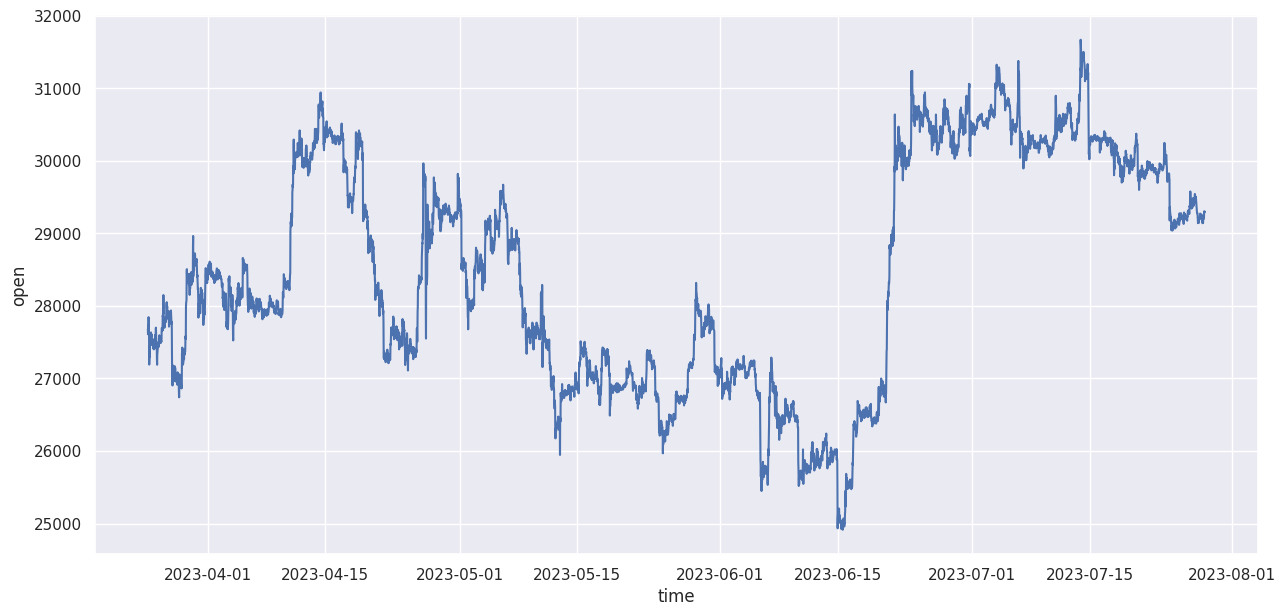

In [214]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df30,x='time',y='open')

<Axes: xlabel='time', ylabel='open'>

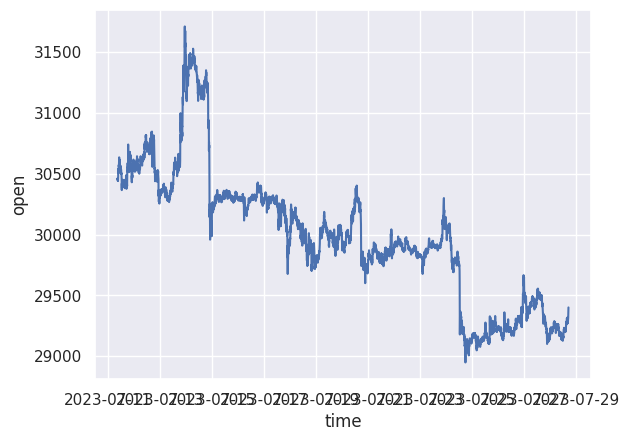

In [215]:
sns.lineplot(data=df5,x='time',y='open')

In [216]:
def check_model_full(model, X, y,df):
    model.fit(X, y)
    y_pred_1 = model.predict(X)
    print(f'r2 {r2_score(y,y_pred_1)}, absolute {mean_absolute_error(y,y_pred_1)}')
    sns.lineplot(data=df[len(df)-len(y):],x='time',y='open')
    sns.lineplot(x=df[len(df)-len(y):].time,y=y_pred_1,c='red')

r2 0.6558606066213065, absolute 728.3656005859375


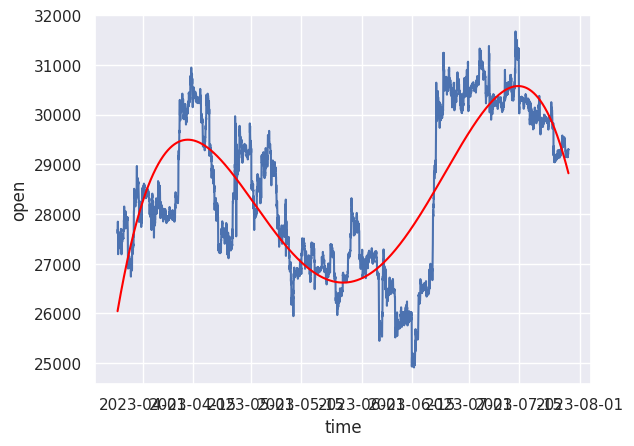

In [217]:
df30['trend_2']=df30.trend**2
df30['trend_3']=df30.trend**3
df30['trend_4']=df30.trend**4
X_time_trend=df30[['trend','trend_2','trend_3','trend_4']]
y=df30['open']
lin_model = Ridge(max_iter=5000)
lin_model.fit(X_time_trend,y)
linear = pd.Series(lin_model.predict(X_time_trend),index=y.index)
check_model_full(Ridge(max_iter=5000), X_time_trend, y,df30)

r2 0.8582189990497098, absolute 413.7551531685244


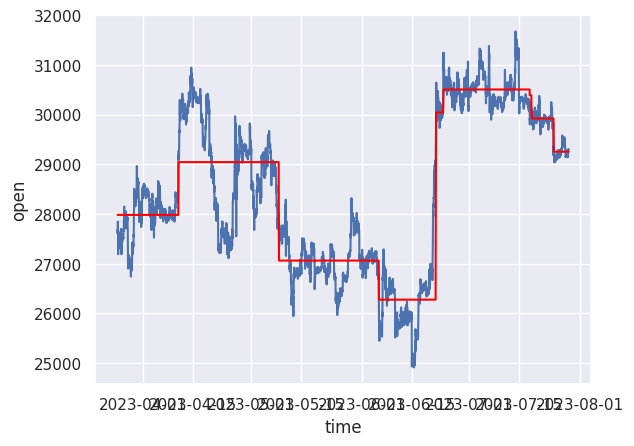

In [218]:
tree_model = RandomForestRegressor(n_estimators=5,max_depth=5)
tree_model.fit(X_time_trend,y)
tree = pd.Series(tree_model.predict(X_time_trend),index=y.index)
check_model_full(RandomForestRegressor(n_estimators=5,max_depth=3), X_time_trend, y,df30)

In [219]:
day_mean = y.rolling(window=48).mean()
day_var = y.rolling(window=48).std()
week_mean = y.rolling(window=48*7).mean()
week_var = y.rolling(window=48*7).std()

In [220]:
time = np.arange(len(y))
freq=365.25*24
order=4
k =  2 * np.pi * (1 / freq) * time
for i in range(1,order+1):
    df30[f'sin_{i}'] = np.sin(i*k)
    df30[f'cos_{i}'] = np.cos(i*k)


In [221]:
X_fourier = df30[['sin_1','cos_1','sin_2','cos_2','sin_3','cos_3','sin_4','cos_4']]

<Axes: xlabel='open_time'>

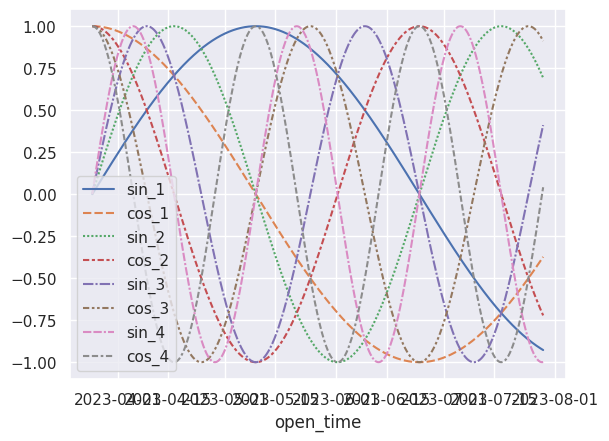

In [222]:
sns.lineplot(X_fourier)

r2 0.7613814270234308, absolute 617.82231957931


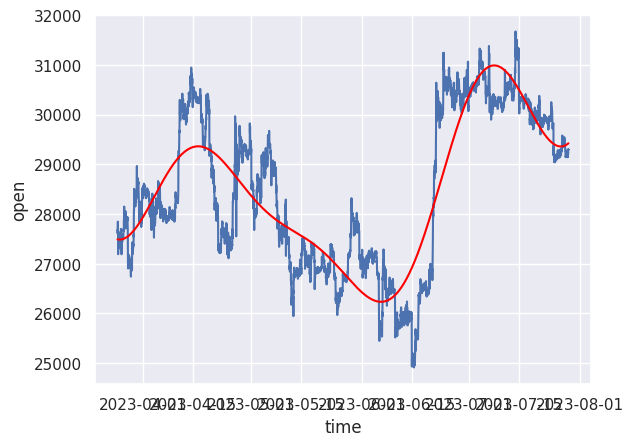

In [223]:
season_model = Lasso()
season_model.fit(X_fourier,y)
seasonal = pd.Series(season_model.predict(X_fourier),index=y.index)
check_model_full(Lasso(),X_fourier,y,df30)

# inserting global features into local dataset

In [224]:
df5.columns

Index(['open', 'high', 'low', 'close', 'volume', 'q_vol', 'trades',
       'taker_buy_volume', 'taker_q_volume', 'ignored', 'trend', 'time'],
      dtype='object')

In [225]:
df5 = df5.drop(['high','low','close','volume','q_vol','trades','taker_buy_volume',
                'taker_q_volume','ignored','trend','time'],axis=1)

In [226]:
features = [linear,tree,seasonal,day_mean,day_var,week_mean,week_var]
def global_into_local(df5,features):
    local_features = []
    n=len(features)
    for i in range(n):
        local_features.append(pd.Series(index=df5.index))
    for i in df5.index:
        if i.minute>=30:
            for j in range(n):
                local_features[j][i] = features[j][i.replace(minute=30)]
        else:
            for j in range(n):
                local_features[j][i] = features[j][i.replace(minute=0)]
    df5['linear'] = local_features[0]
    df5['tree'] = local_features[0]
    df5['seasonal'] = local_features[0]
    df5['day_mean'] = local_features[0]
    df5['day_var'] = local_features[0]
    df5['week_mean'] = local_features[0]
    df5['week_var'] = local_features[0]
            

In [227]:
df5

,open
open_time,
2023-07-11 08:30:00,30462.050781
2023-07-11 08:35:00,30454.080078
2023-07-11 08:40:00,30460.330078
2023-07-11 08:45:00,30441.150391
2023-07-11 08:50:00,30461.070312
...,...
2023-07-28 17:05:00,29304.080078
2023-07-28 17:10:00,29312.380859
2023-07-28 17:15:00,29353.400391


In [228]:
X=df5

In [229]:
dayofmonth = pd.Series(map(lambda x: x.date().day, X.index), index=X.index)
dayofweek = pd.Series(map(lambda x: x.date().weekday(), X.index), index=X.index)
hourofday = pd.Series(map(lambda x: x.time().hour, X.index), index=X.index)

In [230]:
X['day_of_month'] = dayofmonth
X['day_of_week'] = dayofweek
X['hour_of_day'] = hourofday


In [231]:
def add_lags(X,count=72):
    for i in range(1,count+1):
        X[f'lag_{i}'] = X.open.shift(i)

In [232]:
add_lags(X)
X

,open,day_of_month,day_of_week,hour_of_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72
open_time,,,,,,,,,,,,,,,,,,,,,
2023-07-11 08:30:00,30462.050781,11,1,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 08:35:00,30454.080078,11,1,8,30462.050781,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 08:40:00,30460.330078,11,1,8,30454.080078,30462.050781,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 08:45:00,30441.150391,11,1,8,30460.330078,30454.080078,30462.050781,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 08:50:00,30461.070312,11,1,8,30441.150391,30460.330078,30454.080078,30462.050781,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28 17:05:00,29304.080078,28,4,17,29293.419922,29288.000000,29276.750000,29277.210938,29270.000000,29318.980469,...,29172.589844,29176.140625,29184.679688,29172.810547,29179.150391,29163.380859,29152.419922,29136.150391,29132.199219,29147.990234
2023-07-28 17:10:00,29312.380859,28,4,17,29304.080078,29293.419922,29288.000000,29276.750000,29277.210938,29270.000000,...,29150.009766,29172.589844,29176.140625,29184.679688,29172.810547,29179.150391,29163.380859,29152.419922,29136.150391,29132.199219
2023-07-28 17:15:00,29353.400391,28,4,17,29312.380859,29304.080078,29293.419922,29288.000000,29276.750000,29277.210938,...,29152.000000,29150.009766,29172.589844,29176.140625,29184.679688,29172.810547,29179.150391,29163.380859,29152.419922,29136.150391


In [233]:
X.columns

Index(['open', 'day_of_month', 'day_of_week', 'hour_of_day', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31',
       'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38',
       'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45',
       'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'lag_51', 'lag_52',
       'lag_53', 'lag_54', 'lag_55', 'lag_56', 'lag_57', 'lag_58', 'lag_59',
       'lag_60', 'lag_61', 'lag_62', 'lag_63', 'lag_64', 'lag_65', 'lag_66',
       'lag_67', 'lag_68', 'lag_69', 'lag_70', 'lag_71', 'lag_72'],
      dtype='object')

In [234]:
X=X.dropna()
y=X.open
X=X.drop('open',axis=1)

In [235]:
y

open_time
2023-07-11 14:30:00    30434.099609
2023-07-11 14:35:00    30449.990234
2023-07-11 14:40:00    30411.490234
2023-07-11 14:45:00    30398.509766
2023-07-11 14:50:00    30404.250000
                           ...     
2023-07-28 17:05:00    29304.080078
2023-07-28 17:10:00    29312.380859
2023-07-28 17:15:00    29353.400391
2023-07-28 17:20:00    29376.000000
2023-07-28 17:25:00    29400.339844
Name: open, Length: 4932, dtype: float32

In [250]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.01)

In [251]:
def check_model_with_CV(model):
    print(f'CHECKING {model}')
    print()
    model.fit(X_train, y_train)

    print('Mean absolute error in train')
    print(mean_absolute_error(model.predict(X_train),y_train))
    print('Mean absolute error in test (1 percent of all data)')
    print(mean_absolute_error(model.predict(X_test),y_test))

    cv = cross_val_score(
                model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
            )
    print()
    print('CROSS VALIDATION')
    for i in range(len(cv)):
        print(f'mean error in {i+1} split: '+ str(-cv[i]))
    return model

CHECKING LinearRegression()

Mean absolute error in train
16.540686115196866
Mean absolute error in test (1 percent of all data)
11.542875806019584

CROSS VALIDATION
mean error in 1 split: 20.18338233915656
mean error in 2 split: 20.467428660779518
mean error in 3 split: 15.01166721880051
mean error in 4 split: 14.478756591080083
mean error in 5 split: 13.778360382622374


<Axes: xlabel='open_time', ylabel='open'>

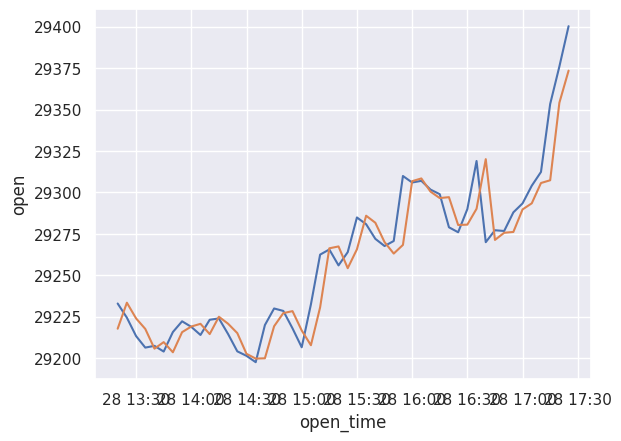

In [252]:
lr = check_model_with_CV(LinearRegression())

sns.lineplot(y_test)
sns.lineplot(pd.Series(lr.predict(X_test), index = y_test.index))

CHECKING RandomForestRegressor(max_depth=5, n_estimators=5)

Mean absolute error in train
19.76985489540255
Mean absolute error in test (1 percent of all data)
12.198566168651887

CROSS VALIDATION
mean error in 1 split: 34.32781072193241
mean error in 2 split: 98.21025796069824
mean error in 3 split: 19.500095610079374
mean error in 4 split: 255.00652506766454
mean error in 5 split: 55.798867950706594


<Axes: xlabel='open_time', ylabel='open'>

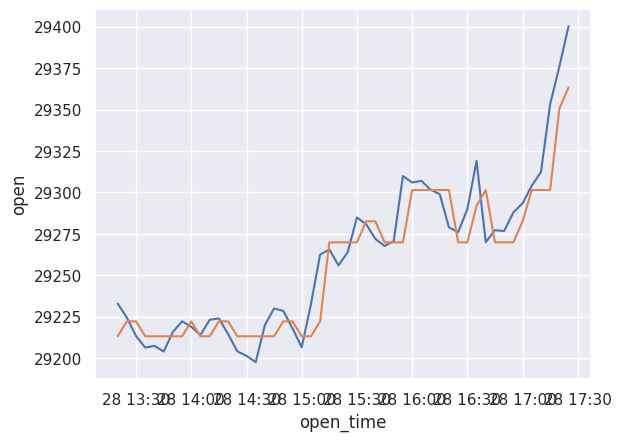

In [253]:
tree = check_model_with_CV(RandomForestRegressor(n_estimators=5, max_depth=5))

sns.lineplot(y_test)
sns.lineplot(pd.Series(tree.predict(X_test), index = y_test.index))

CHECKING Lasso(alpha=5, max_iter=5000)

Mean absolute error in train
16.56015536053009
Mean absolute error in test (1 percent of all data)
11.26727367837324

CROSS VALIDATION
mean error in 1 split: 17.492844713948575
mean error in 2 split: 20.24794836123901
mean error in 3 split: 14.758261777362447
mean error in 4 split: 14.387455130251308
mean error in 5 split: 13.7024982395625


<Axes: xlabel='open_time', ylabel='open'>

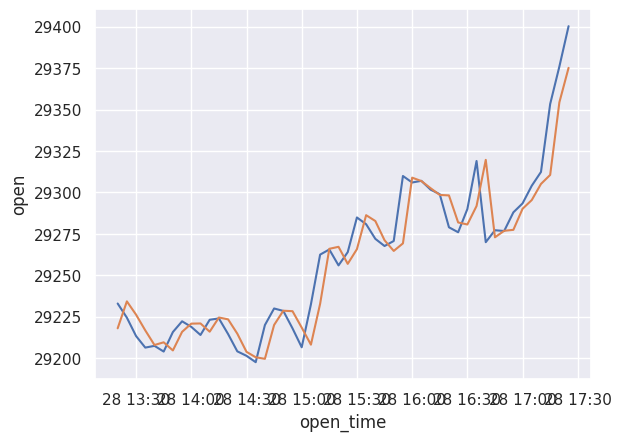

In [254]:
lasso = check_model_with_CV(Lasso(alpha=5,max_iter=5000))

sns.lineplot(y_test)
sns.lineplot(pd.Series(lasso.predict(X_test), index = y_test.index))

CHECKING Ridge(alpha=100, max_iter=5000)

Mean absolute error in train
16.540537361377513
Mean absolute error in test (1 percent of all data)
11.5426519364446

CROSS VALIDATION
mean error in 1 split: 19.70631998026014
mean error in 2 split: 20.469659409554687
mean error in 3 split: 15.008067691952045
mean error in 4 split: 14.47922516700796
mean error in 5 split: 13.77828798029498


<Axes: xlabel='open_time', ylabel='open'>

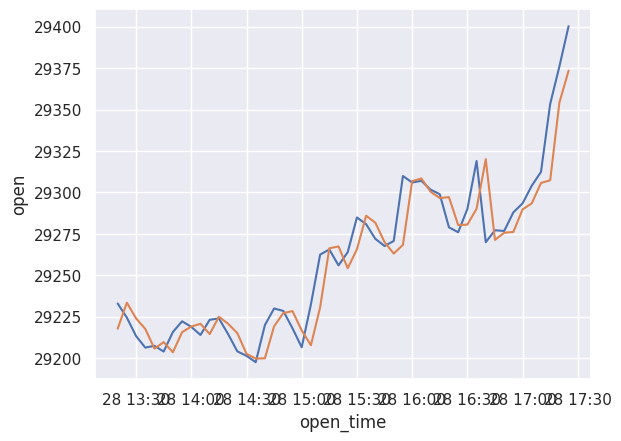

In [255]:
ridge = check_model_with_CV(Ridge(alpha=100,max_iter=5000))

sns.lineplot(y_test)
sns.lineplot(pd.Series(ridge.predict(X_test), index = y_test.index))

In [260]:
def day_str(day):
    if day<=9:
        return '0'+str(day)
    return str(day)
def month_profit(model_fitted, month,start):
    total_profit = 0
    for day in range(15,30):
        sum_day = 0
        y_day = y[(y.index >= f"{month}-{day_str(day)} 00:00:00") & (y.index <= f"{month}-{day_str(day+1)} 00:00:00")]
        X_day = X[(X.index >= f"{month}-{day_str(day)} 00:00:00") & (X.index <= f"{month}-{day_str(day+1)} 00:00:00")]
        if len(y_day)>0:
            y_pred = model_fitted.predict(X_day)
        for i in range(1, len(y_day)):
            #if True:
            if y_pred[i]-y_day[i-1]>0:
                sum_day += ((start)*(y_day[i]/y_day[i-1]-1))
                start+=((start)*(y_day[i]/y_day[i-1]-1))
            if y_pred[i]-y_day[i-1]<=0:
                #pass
                sum_day += -((start)*(y_day[i]/y_day[i-1]-1))
                start+=-((start)*(y_day[i]/y_day[i-1]-1))
        print(f'Profit for day {day} is {sum_day}. Current money: {start}')
        total_profit += sum_day
    print()
    print()
    return start

In [263]:
month='2023-07'
print(f'Total profit for {month} is {month_profit(lr,month,100)-100}')

Profit for day 15 is 0.5216581095169879. Current money: 100.52165810951705
Profit for day 16 is 2.222200302978609. Current money: 102.74385841249553
Profit for day 17 is 3.2893142003182816. Current money: 106.03317261281377
Profit for day 18 is 4.12513592290164. Current money: 110.15830853571542
Profit for day 19 is 1.9665924435637967. Current money: 112.12490097927909
Profit for day 20 is 4.034884354992104. Current money: 116.15978533427112
Profit for day 21 is 4.391743854230822. Current money: 120.55152918850187
Profit for day 22 is -0.682997510937075. Current money: 119.86853167756459
Profit for day 23 is 0.7149374698961202. Current money: 120.58346914746085
Profit for day 24 is 4.206710626766046. Current money: 124.79017977422684
Profit for day 25 is 1.0456618156471298. Current money: 125.83584158987402
Profit for day 26 is 4.081860473243356. Current money: 129.91770206311736
Profit for day 27 is 5.152348360957304. Current money: 135.07005042407465
Profit for day 28 is 1.0008291761